# Atividade 01: Implementando um Classificador *k Vizinhos Mais Próximos* (*kNN*)

Nesta atividade, você irá treinar um classificador *kNN* e irá testá-lo utilizando o dataset CIFAR-10;

O classificador *kNN* consiste de duas etapas:

1. Durante o treinamento, o classificador simplesmente armazena os dados de treinamento
2. Durante o teste, o classificador calcula a distância entre cada objeto de teste e todos os dados de treinamento, utilizando os rótulos dos k mais similares (ou próximos) para determinar o rótulo dos objetos de teste

O valor de $k$ pode ser determinado via validação cruzada, por exemplo.

Neste atividade, você irá:

- testar a implementação dos passos de **treinamento e teste de um classificador kNN**
- **entender as etapas** básicas (*pipeline*) **da classificação de imagens**
- **explorar** o uso da **validação cruzada** 
- **explorar a escrita de código** eficiente e paralelo/vetorizado


## Preparação para usar o *Colaboratory*

Caso você deseje usar o *Colaborabory*, execute os comandos da célula a seguir para conseguir acessar os arquivos em uma conta do **Google Drive**.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Além disso, você talvez deseje trabalhar um subdiretório (ou pasta) específico, por exemplo `Pratica1`.  Esse diretório (ou pasta) já deve ter sido criado e conter o ***notebook*** dessa prática.

Sendo assim, utilize as instruções na próxima célula para alterar o diretório corrente para esse subdiretório (alterando o nome do subdiretório, se for o caso).

In [ ]:
import os
os.chdir("drive/My Drive/Pratica1")

## Obtendo o conjunto de dados CIFAR-10

Nesta atividade, você irá desenvolver uma rede neural para realizar classificação de imagens e irá testá-la utilizando o dataset CIFAR-10. 

Para tando, você deve obter as imagens dessa base de dados executando a célula a seguir.

**OBS: Você só precisar realizar esta etapa uma vez!** Caso você já a tenha feito anteriormente e está retornando para continuar a execução dessa prática, não será necessário que se faça a recuperação das imagens novamente. Para verificar se os dados da base estão disponíveis, basta checar a existência do subdiretório `cifar-10-batches-py` no diretório corrente.

In [ ]:
!wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xzvf cifar-10-python.tar.gz
!rm cifar-10-python.tar.gz

## Código de inicialização e configuração básica

Execute a célula a seguir para garantir a importação de alguns recursos básicos, bem como a inicialização/configuração para exibição correta de gráficos. 

In [2]:
# Executa algum código de inicialização desse notebook.

import random
import numpy as np
import matplotlib.pyplot as plt
# from past.builtins import range

from __future__ import print_function

# Um pouco de 'mágica': Isto permite que as figuras geradas pela biblioteca matplotlib apareçam dentro do notebook
# ao invés de aparecer em uma nova janela.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # fixa tamanho default para as plotagens
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Um pouco mais de 'mágica', assim o notebook irá recarregar módulos python externos;
# veja mais em http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Carregamento de dados
Agora que você testou uma rede de duas camadas passando pela verificação de gradientes e seu funcionado sobre o pequeno conjunto de dados, é hora de carregar os dados do **CIFAR-10 dataset** de modo que você possa usá-los no treinamento de um classificador sobre dados reais.

In [3]:
from __future__ import print_function

from six.moves import cPickle as pickle
import numpy as np
import os
import platform

def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))

def load_CIFAR_batch(filename):
  """ load single batch of cifar """
  with open(filename, 'rb') as f:
    datadict = load_pickle(f)
    X = datadict['data']
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
    Y = np.array(Y)
    return X, Y

def load_CIFAR10(ROOT):
  """ load all of cifar """
  xs = []
  ys = []
  for b in range(1,6):
    f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
    X, Y = load_CIFAR_batch(f)
    xs.append(X)
    ys.append(Y)    
  Xtr = np.concatenate(xs)
  Ytr = np.concatenate(ys)
  del X, Y
  Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
  return Xtr, Ytr, Xte, Yte

# Carrega os dados brutos da base CIFAR-10.
# Para tanto, você deve ter feito o download de http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
cifar10_dir = 'cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# Apenas para verificação, vamos exibir o tamanho dos dados de treinamento e teste.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


## Visualizando amostras dos dados
Utilize a célula a seguir para visualizar algumas amostras das 10 classes de imagens da base `CIFAR-10`

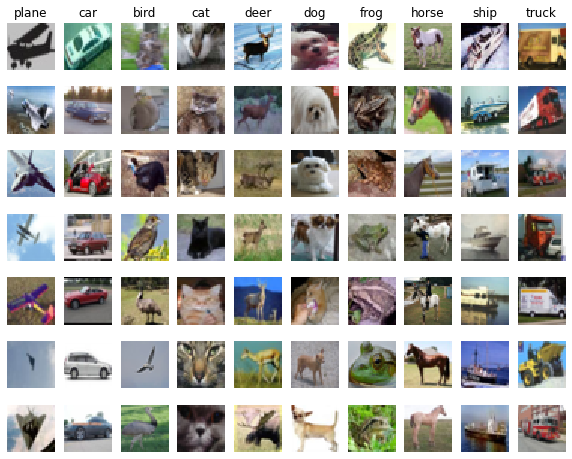

In [4]:
# Visualizar alguns exemplos do dataset.
# São exibidos apenas 7 exemplos de imagens de treinamento de cada classe.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

## Preparação de dados
É importante para facilitar o treinamento que seja feito algum tipo de preparação dos dados. Neste caso, está se realizando uma simples subamostragem dos dados para maior eficiência na execução do código dessa atividade

In [5]:
# Realiza subamostragem dos dados para maior eficiência na execução do código desse exercício
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# Reformata os dados das imagens, assim as matrizes são transformadas em vetores
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


## Código para Classe implementando o Classificador *kNN*

Nesta atividade será utilizada a classe `KNearestNeighbor`  para representar instâncias de um classificador *kNN*. Esta classe se encontra definida dentro da célula abaixo.


In [6]:
class KNearestNeighbor(object):
  """ a kNN classifier with L2 distance """

  def __init__(self):
    pass

  def train(self, X, y):
    """
    Train the classifier. For k-nearest neighbors this is just 
    memorizing the training data.

    Inputs:
    - X: A numpy array of shape (num_train, D) containing the training data
      consisting of num_train samples each of dimension D.
    - y: A numpy array of shape (N,) containing the training labels, where
         y[i] is the label for X[i].
    """
    self.X_train = X
    self.y_train = y
    
  def predict(self, X, k=1, num_loops=0):
    """
    Predict labels for test data using this classifier.

    Inputs:
    - X: A numpy array of shape (num_test, D) containing test data consisting
         of num_test samples each of dimension D.
    - k: The number of nearest neighbors that vote for the predicted labels.
    - num_loops: Determines which implementation to use to compute distances
      between training points and testing points.

    Returns:
    - y: A numpy array of shape (num_test,) containing predicted labels for the
      test data, where y[i] is the predicted label for the test point X[i].  
    """
    if num_loops == 0:
      dists = self.compute_distances_no_loops(X)
    elif num_loops == 1:
      dists = self.compute_distances_one_loop(X)
    elif num_loops == 2:
      dists = self.compute_distances_two_loops(X)
    else:
      raise ValueError('Invalid value %d for num_loops' % num_loops)

    return self.predict_labels(dists, k=k)

  def compute_distances_two_loops(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using a nested loop over both the training data and the 
    test data.

    Inputs:
    - X: A numpy array of shape (num_test, D) containing test data.

    Returns:
    - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
      is the Euclidean distance between the ith test point and the jth training
      point.
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in range(num_test):
      for j in range(num_train):
        dists[i, j] = np.sqrt(np.sum(np.square(self.X_train[j] - X[i])))
    return dists

  def compute_distances_one_loop(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using a single loop over the test data.

    Input / Output: Same as compute_distances_two_loops
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in range(num_test):
      dists[i, :] = np.sqrt(np.sum(np.square(self.X_train - X[i,:]), axis = 1))
    return dists

  def compute_distances_no_loops(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using no explicit loops.

    Input / Output: Same as compute_distances_two_loops
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train)) 
    x2 = np.sum(X**2, axis=1).reshape((num_test,1))
    y2 = np.sum(self.X_train**2, axis=1).reshape((1,num_train))
    xy = X.dot(self.X_train.T)
    dists = np.sqrt(x2+y2-2*xy)
    return dists

  def predict_labels(self, dists, k=1):
    """
    Given a matrix of distances between test points and training points,
    predict a label for each test point.

    Inputs:
    - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
      gives the distance betwen the ith test point and the jth training point.

    Returns:
    - y: A numpy array of shape (num_test,) containing predicted labels for the
      test data, where y[i] is the predicted label for the test point X[i].  
    """
    num_test = dists.shape[0]
    y_pred = np.zeros(num_test)
    for i in range(num_test):
      # A list of length k storing the labels of the k nearest neighbors to
      # the ith test point.
      closest_y = []
      closest_y = self.y_train[np.argsort(dists[i,:])[:k]]
      y_pred[i] = np.argmax(np.bincount(closest_y))

    return y_pred


# Cria uma instância do classificador kNN. 
# Lembre-se que o treinamento de um classificador kNN é trivial: 
# o classificador simplemente armazena os dados sem nenhum processamento adicional 
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

Agora, você deve classificar os dados de teste com o classificador kNN. Lembre-se de que esse processo pode ser dividido em dois passos:

1. Primeiro, deve-se calcular as distâncias entre todas as amostras de teste e todos os dados de treinamento.
2. Dadas essas distâncias, para cada amostra de teste, deve-se encontrar os k exemplos mais próximos entre os dados de treinamento e utilizá-los para uma **votação**, de forma a determinar o rótulo da amostra teste.

Vamos iniciar calculando a matriz de distância entre todos os dados de treinamento e amostras de teste. Por exemplo, se existirem **Ntr** exemplos de treinamento e **Nte** amostras de teste, esta etapa resulta em uma matriz **Nte x Ntr**, em que cada elemento (*i*, *j*) representa a distância entre a *i*-ésima amostra de teste e o *j*-ésimo exemplos de treinamento. 

Primeiramente, você deve experimentar com a função `compute_distances_two_loops` que utiliza dois laços (muito ineficiente) para iterar sobre todos os pares de exemplos (teste, treino) e calcular a matriz de distância (um elemento por vez).

In [7]:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


## Visualizando a Matriz de Distâncias do Classificador *kNN*

O código da célula abaixo pode ser usado para se visualizar a matriz de distância: cada linha está associada a uma única amostra de teste e suas distâncias para os exemplos de treinamento.

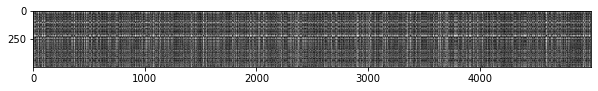

In [8]:
# Pode-se visualizar a matriz de distância: cada linha está associada a uma única amostra de teste
# e suas distâncias para os exemplos de treinamento
plt.imshow(dists, interpolation='none')
plt.show()

**Pergunta #1:** Observe os padrões que surgem na matriz de distância, em que algumas linhas e colunas são visivelmente mais claras (vale dizer que o esquema de cores padrão que foi utilizado, preto indica distâncias pequenas enquanto branco representa distâncias grandes).

- O que você pode dizer sobre os dados que explique as linhas mais claras?
- E, em relação as colunas mais claras?

**Sua Resposta**: *Preencha aqui.*
</p>Linhas -> As distâncias entre determinado elemento de treino é maior em relação a teste.<p>
</p>Colunas -> Provável não existir correspondência entre treino e teste.<p>


## Realizando Predições com o Classificador *kNN*

Em seguida, pode-se realizar predições utilizando a matriz de distância calculada. Para tanto, você utilizar a função `predict_labels`. 

In [10]:
# Agora, você pode testar a função predict_labels executando o código a seguir:
# Utilizou-se k = 1 (que representa o suo apenas do VIZINHO MAIS PRÓXIMO).
y_test_pred = classifier.predict_labels(dists, k=1)

# Calcula e exibe a fração de amostras corretamente preditas
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


Você deve esperar ver aproximadamente `27%` de acurácia. Agora, vamos experimentar com um valor maior de `k`, p.ex. `k = 5`:

In [11]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 139 / 500 correct => accuracy: 0.278000


Você deve esperar ver uma performance ligeiramente melhor que a obtida com `k = 1`.

## Explorando o paralelismo para melhorar a eficiência

Agora, vamos tentar aumentar a velocidade de execução utilizando operações vetoriais!

Primeiro, elimina-se uma dos laços...


In [12]:
# Primeiro, vamos acelerar o cálculo da matriz de distância por meio da paralelização 
# de um dos laços. A implementação se encontra na função compute_distances_one_loop 
# dentro da classe KNearestNeighbor

# Examine o código da função e, depois, execute o código abaixo:
dists_one = classifier.compute_distances_one_loop(X_test)

# Para se garantir que sua implementação paralelizada está correta, deve-se verificar
# que seu resultado coincide com o da implementação ingênua (ou trivial).

# Existem várias de se decidir se duas matrizes são similares; uma das formas mais 
# simples é a norma de Frobenius. Caso você não a conheça, a norma de Frobenius de 
# duas matrizes é a raiz quadrada da soma dos quadrados das diferenças entre todos  
# os elementos correspondentes das duas matrizes. Em outras palavras, é como se 
# reformatássemos as matrizes como vetores e calculássemos a distância euclidiana
# entre eles.

difference = np.linalg.norm(dists - dists_one, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


Em seguida, vamos **eliminar todos os laços!**

In [13]:
# Em seguida, utiliza o cálculo da matriz de distância completamente vetorizado 
#por meio da função compute_distances_no_loops e teste com o código abaixo
dists_two = classifier.compute_distances_no_loops(X_test)

# Verifique se a matriz de distância obtida coincide com a calculada anteriormente:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


Vamos comparar a eficiência dessas três implementações!

In [14]:
# Agora, pode-se comparar a velocidade de suas implementações
def time_function(f, *args):
    """
    Chama uma funcao f com args e retorna o tempo (em segundos) que ela levou para executar.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

# OBS: você deve ver uma execução significativamente mais rápida com a implementação completamente vetorizada

Two loop version took 34.111341 seconds
One loop version took 27.538653 seconds
No loop version took 0.186889 seconds


### Validação cruzada

Nesse ponto, você já implementou o classificador kNN, contudo o valor de k = 5 foi definido de forma arbitrária.

Pode-se agora procurar determinar o melhor valor para esse hiperparâmetro por meio de validação cruzada.

In [15]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)

################################################################################
# TODO:                                                                        #
# Dividir os dados de treinamento em partições. Depois disso, X_train_folds    #
# e y_train_folds devem ser listas de tamanho num_folds, em que:               #
# y_train_folds[i] é o vetor de rótulos para os pontos em X_train_folds[i].    #
# DICA: Experimente usar a função array_split da biblioteca numpy.             #
################################################################################
# pass
################################################################################
#                              FIM DE SEU CÓDIGO                               #
################################################################################

# Declarou-se a seguir um dicionário para conter os valores de acurácia para 
# diferentes valores de k que forem encontrados durante a validação cruzada.
#
from itertools import chain
numy = y_train_folds[0].shape[0]

k_to_accuracies = {}
for k in k_choices:
    k_to_accuracies[k] = []
    for i in range(num_folds):
        j = [x for x in range(num_folds) if x != i]
        xtrain = []
        ytrain = []
        for x in j: 
            xtrain.append(X_train_folds[x])
            ytrain.append(y_train_folds[x])
        xtrain = np.array(list(chain.from_iterable(xtrain)))
        ytrain = np.array(list(chain.from_iterable(ytrain)))
        classifier = KNearestNeighbor()
        classifier.train(xtrain, ytrain)
        # dists = classifier.compute_distances_no_loops(X_train_folds[i])
        ypred = classifier.predict(X_train_folds[i], k=k)
        num_correct = np.sum(ypred == y_train_folds[i])
        k_to_accuracies[k].append(float(num_correct) / numy)

# Depois de executada a validação cruzada, espera-se que k_to_accuracies[k] 
# seja uma lista de tamanho igual a num_folds contendo os diferentes valores 
# de acurácia associados a esse valor de k que foram obtidos para cada um dos
# particionamentos

################################################################################
# TODO:                                                                        #
# Realizar a validação cruzada de k subconjuntos (folds) para encontrar o      #
# melhor valor de k. Para cada valor possível de k, executar o classificador   #
# kNN várias vezes (num_folds repetições), de forma que em cada execução       #
# todos com exceção de um dos subconjuntos (folds) são usados como dados de    #
# treinamento e o subconjunto deixado a parte é usado como conjunto de         #
# validação. Armazenar as acurácias obtidas para todos os subconjuntos e para  #
# todos os valores de k no dicionário denominado k_to_accuracies.              # 
################################################################################
# pass
################################################################################
#                              FIM DE SEU CÓDIGO                               #
################################################################################

# Exibe as acurácias calculadas
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 3, accuracy = 0.239000
k = 3, accuracy = 0.249000
k = 3, accuracy = 0.240000
k = 3, accuracy = 0.266000
k = 3, accuracy = 0.254000
k = 5, accuracy = 0.248000
k = 5, accuracy = 0.266000
k = 5, accuracy = 0.280000
k = 5, accuracy = 0.292000
k = 5, accuracy = 0.280000
k = 8, accuracy = 0.262000
k = 8, accuracy = 0.282000
k = 8, accuracy = 0.273000
k = 8, accuracy = 0.290000
k = 8, accuracy = 0.273000
k = 10, accuracy = 0.265000
k = 10, accuracy = 0.296000
k = 10, accuracy = 0.276000
k = 10, accuracy = 0.284000
k = 10, accuracy = 0.280000
k = 12, accuracy = 0.260000
k = 12, accuracy = 0.295000
k = 12, accuracy = 0.279000
k = 12, accuracy = 0.283000
k = 12, accuracy = 0.280000
k = 15, accuracy = 0.252000
k = 15, accuracy = 0.289000
k = 15, accuracy = 0.278000
k = 15, accuracy = 0.282000
k = 15, accuracy = 0.274000
k = 20, accuracy = 0.270000
k = 20, accu

## Representando graficamente os resultados obtidos


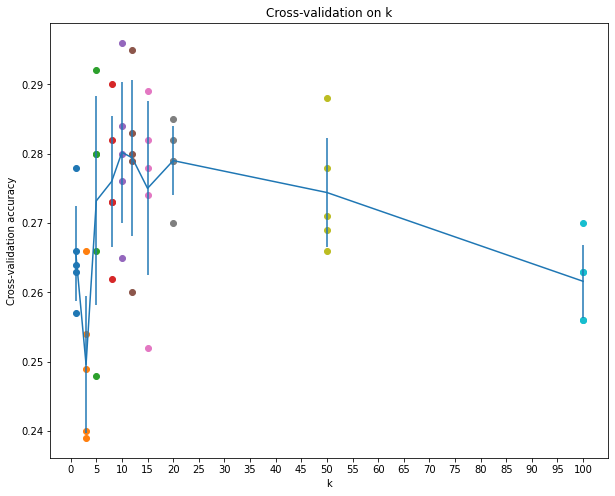

In [17]:
# Plota as observações brutas
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# Plota linha de tendência com barras de erro que correspondem ao desvio padrão 
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.xticks(range(0, 105, 5))
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

## Selecionando um valor ideal para *k* e realizando o teste

Com base nos resultados anterioes da validação cruzada, escolha o melhor valor para *k* (e insira na primeiro linha da célula abaixo como 'best_k'). Em seguida, treine novamente o classificador e realize os testes.

Você deve ser capaz de obter uma acurácia acima de 28% nos dados de teste.

In [18]:
best_k = 10

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Calcula e exibe a acurácia
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 141 / 500 correct => accuracy: 0.282000
